In [1]:
from aocd.models import Puzzle

puzzle = Puzzle(year=2022, day=17)

def parses(input):
    return input
        
data = parses(puzzle.input_data)

In [2]:
# def render(piece):
#     matrix = [[' ' for i in range(5)] for j in range(5)]
#     for x, y in pieces[piece]:
#         matrix[x][y] = '@'
#     matrix = np.rot90(matrix)
#     print('\n'.join([''.join(row) for row in matrix]))
# render('L')    

In [3]:
sample = '>>><<><>><<<>><>>><<<>>><<<><<<>><>><<>>'

In [4]:
from PIL import Image
def visualize(chamber, piece_loc, zoom=20):
    chamber = chamber.copy()
    chamber[tuple(piece_loc.T)] = 1
    chamber = 255 * np.rot90(chamber)
    chamber = np.repeat(chamber, zoom, axis=0)
    chamber = np.repeat(chamber, zoom, axis=1)
    chamber[:,::zoom] = 128
    chamber[::zoom,:] = 128
    im = Image.fromarray(chamber)
    return im


In [8]:
def solve_a(data, steps=2022):
    pieces = {
        '-': [(i,0) for i in range(4)],
        '+': [(0,1),(1,0),(1,1),(1,2),(2,1)],
        'L': [(0,0),(1,0),(2,0),(2,1),(2,2)],
        '|': [(0,i) for i in range(4)],
        'o': [(0,0),(0,1),(1,0),(1,1)],
    }

    piece_order = "-+L|o"

    height = {'-': 1, '+': 3, 'L': 3, '|': 4, 'o': 2}

    chamber = np.zeros((7,1), dtype=np.uint8)
    maxy = -1
    
    j = 0
    DOWN = np.array([0,-1])
    LEFT = np.array([-1,0])
    RIGHT = np.array([+1,0])

    for i in range(steps):
        piece_type = piece_order[i%len(piece_order)]
        piece = pieces[piece_type]
        
        x, y = 2, 4 + maxy

        # pad if needed
        chamber_height = chamber.shape[1]
        if y + height[piece_type] >= chamber_height:
            pad = np.zeros((7,y-+height[piece_type]+chamber_height+1), np.uint8)
            chamber = np.hstack([chamber, pad])

        loc = np.array([x,y]) + np.array(piece)
        
#         display(visualize(chamber, loc))

        while True:
            jet = {'<': LEFT, '>': RIGHT}[data[j]]
            j = (j+1) % len(data)
            
            new_loc = loc + jet
            
            if new_loc[:,0].min() >= 0 and new_loc[:,0].max() < 7 and (chamber[tuple(new_loc.T)] == 0).all():
                loc = new_loc
            
            new_loc = loc + DOWN
            
            if new_loc[:,1].min() >= 0 and (chamber[tuple(new_loc.T)] == 0).all():
                loc = new_loc
            else:
                chamber[tuple(loc.T)] = 1
                maxy = max(maxy, loc[:,1].max())
                break

    return 1+maxy
                

In [9]:
solve_a(sample)

3068

In [10]:
solve_a(data)

3090

In [95]:
def simulate(data, steps):
    # constants
    pieces = { # relative coords wrt bottom-left corner
        '-': np.array([(i,0) for i in range(4)]),
        '+': np.array([(0,1),(1,0),(1,1),(1,2),(2,1)]),
        'L': np.array([(0,0),(1,0),(2,0),(2,1),(2,2)]),
        '|': np.array([(0,i) for i in range(4)]),
        'o': np.array([(0,0),(0,1),(1,0),(1,1)]),
    }
    piece_order = "-+L|o"
    height = {'-': 1, '+': 3, 'L': 3, '|': 4, 'o': 2}

    # state
    chamber = np.zeros((7,1), dtype=np.uint8)
    maxy = -1
    
    j = 0
    DOWN, LEFT, RIGHT = np.array([0,-1]), np.array([-1,0]), np.array([+1,0])
    # 
    maxy_increments = []
    for i in range(steps):
        piece_type = piece_order[i%len(piece_order)]
        piece = pieces[piece_type]
        
        x, y = 2, 4 + maxy # as per the rules

        # pad if needed
        maxh = chamber.shape[1]
        h = height[piece_type]
        if y + h  >= maxh:
            pad = np.zeros((7,y-h+maxh+1), np.uint8)
            chamber = np.hstack([chamber, pad])

        # absolute location
        loc = np.array([x,y]) + piece
        
        while True:
            jet = {'<': LEFT, '>': RIGHT}[data[j]]
            j = (j+1) % len(data) # increment mod length
            
            new_loc = loc + jet
            
            # if possible move sideways
            if new_loc[:,0].min() >= 0 and new_loc[:,0].max() < 7 and (chamber[tuple(new_loc.T)] == 0).all():
                loc = new_loc
            
            new_loc = loc + DOWN
            
            # if possible move down
            if new_loc[:,1].min() >= 0 and (chamber[tuple(new_loc.T)] == 0).all():
                loc = new_loc
            else:
                # cannot move down
                chamber[tuple(loc.T)] = 1
                prev_maxy = maxy
                maxy = max(maxy, loc[:,1].max())
                maxy_increments.append(maxy-prev_maxy)
                break

    return np.array(maxy_increments)
                

In [147]:
def solve_a(data):
    return np.sum(simulate(data, steps=2022))

In [148]:
solve_a(sample)

3068

In [149]:
solve_a(data)

3090

In [171]:
def solve_b(data):
    # Idea is to ignore the board state altogether and just focus on what
    # we know must repeat (as per the question): the max_y increments
    # There will be a loop in the increments, we just need to find the period
    # Fourier analysis seems tempting but it's actually simpler to just 
    # do boolean cross correlation and pick offsets with high similarity
    maxy_incs = simulate(data, steps=10_000)
    
    def similarity(x):
        return np.array([(x[:-i] == x[i:]).sum() for i in range(1,len(x))])
    
    # correlate signal with shifted version and pick indices of high agreement
    s = similarity(maxy_incs)
    high_similarity = np.argwhere(s > len(s)/2).T[0]
    periods = np.diff(high_similarity) 
    # Check period uniqueness
    assert len(set(periods.tolist())) == 1
    period = periods[0]
    # there's a prefix that does not repeat, afterwards it repeats
    # luckily (or likely because of puzzle building constraints),
    # the prefix is the same length
    assert (maxy_incs[period:2*period] == maxy_incs[2*period:3*period]).all()
    inc_period = maxy_incs[period:2*period]
    # Compute maxy_increment sum via modular arithmetic
    step = 1_000_000_000_000
    initial_inc = np.sum(maxy_incs[:period]) # prefix is different
    q, r = divmod(step, period)
    return initial_inc + (q-1) * inc_period.sum() + inc_period[:r].sum()

In [172]:
solve_b(sample) == 1514285714288

True

In [173]:
solve_b(data)

1530057803453

1530057803453

In [133]:
T, incs = solve_b(data)

In [136]:
(incs[T:2*T] == incs[2*T:3*T]).all()

True

In [137]:
(incs[3*T:4*T] == incs[2*T:3*T]).all()

True

In [139]:
(incs[:T] == incs[T:2*T]).mean()

0.923699421965318

In [89]:
ds = solve_b(data, steps=20_000)

In [90]:
from numba import njit

def find_shift(x):
    for i in range(1,len(x)):
        if (x[:-i] == x[i:]).all():
            return i



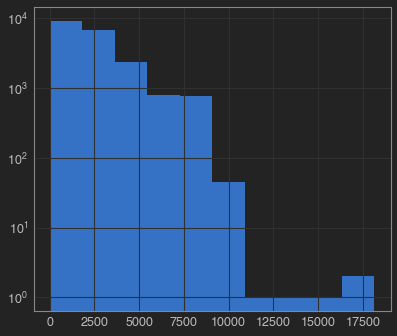

In [92]:
plt.hist(s)
plt.yscale('log')

array([1730, 1730, 1730, 1730])

In [96]:
s[]

array([18138, 16408, 14678, 12948, 11218])

In [94]:
np.diff(sorted(s[s > len(s)/2]))

array([1730, 1730, 1730, 1730])

In [76]:
F = np.fft.fft(ds)

<StemContainer object of 3 artists>

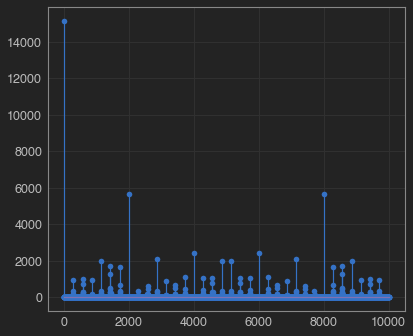

In [80]:
plt.stem(abs(F))

In [79]:
np.argwhere(abs(F[1:]) > 500)

array([[ 285],
       [ 570],
       [ 571],
       [ 856],
       [1142],
       [1427],
       [1428],
       [1429],
       [1713],
       [1714],
       [1999],
       [2570],
       [2856],
       [3142],
       [3427],
       [3428],
       [3713],
       [3999],
       [4285],
       [4570],
       [4571],
       [4856],
       [5142],
       [5427],
       [5428],
       [5713],
       [5999],
       [6285],
       [6570],
       [6571],
       [6856],
       [7142],
       [7428],
       [7999],
       [8284],
       [8285],
       [8569],
       [8570],
       [8571],
       [8856],
       [9142],
       [9427],
       [9428],
       [9713]])

In [48]:
find_shift(ds)

In [40]:
ds.shape

(10000,)

In [41]:
a = np.correlate(ds,ds,mode='full')

In [42]:
np.where(a==np.correlate(ds,ds))

(array([9999]),)

In [43]:
a.shape

(19999,)

In [44]:
np.correlate(ds,ds)

array([37440])

In [9]:
from numba import njit

In [10]:
# @njit
# def solve_a(data, steps=2022):

#     height = np.array([1,3,3,4,2])

#     chamber = np.zeros((7,1), dtype=np.uint8)
#     maxy = -1
    
#     j = 0
#     DOWN = np.array([0,-1])
#     LEFT = np.array([-1,0])
#     RIGHT = np.array([+1,0])
    
#     for i in range(steps):
#         piece_type = i % 5
#         if i == 0:
#             piece = np.array([[0,0],[1,0],[2,0],[3,0]])
#         elif i == 1:
#             piece = np.array([[0,1],[1,0],[1,1],[1,2],[2,1]])
#         elif i == 2:
#             piece = np.array([[0,0],[1,0],[2,0],[2,1],[2,2]])
#         elif i == 3:
#             piece = np.array([[0,0],[0,1],[0,2],[0,3]])
#         elif i == 4:
#             piece = np.array([[0,0],[0,1],[1,0],[1,1]])
            
#         x, y = 2, 4 + maxy

#         # pad if needed
#         chamber_height = chamber.shape[1]
#         if y + height[piece_type] >= chamber_height:
#             pad = np.zeros((7,y-+height[piece_type]+chamber_height+1), np.uint8)
#             chamber = np.hstack((chamber, pad))

#         loc = np.array([[x,y]]) + piece
        
        
# #         display(visualize(chamber, loc))

#         while True:
#             jet = {'<': LEFT, '>': RIGHT}[data[j]]
#             j = (j+1) % len(data)
            
#             new_loc = loc + jet

#             if new_loc[:,0].min() >= 0 and new_loc[:,0].max() < 7:
#                 for x, y in new_loc:
#                     if chamber[x,y] == 1:
#                         break
#                 else:
#                     loc = new_loc
            
#             new_loc = loc + DOWN

#             if new_loc[:,1].min() >= 0:
#                 for x, y in new_loc:
#                     if chamber[x,y] == 1:
#                         break
#                 else:
#                     loc = new_loc
#             else:
#                 for x, y in loc:
#                     chamber[x,y] = 1
#                 maxy = max(maxy, loc[:,1].max())
#                 break

#     return 1+maxy
                